# Legal-OS: Complete M&A Document Analysis System

This notebook demonstrates the entire Legal-OS pipeline in a single, cohesive workflow.
It combines all Epic demonstrations (E01-E08) with shared resources and progressive complexity.

## System Overview

Legal-OS is an AI-powered M&A due diligence system featuring:
- **Document Ingestion & RAG** - Process legal documents with vector search
- **Clause Extraction** - Identify M&A clauses with LangGraph agents
- **Risk Scoring** - Assess risks with rule-based heuristics
- **Summary Generation** - Create comprehensive diligence memos
- **Source Tracking** - Maintain provenance for all findings
- **Checklist Generation** - Produce actionable follow-up items
- **Orchestration** - Coordinate all agents in a unified workflow

## Notebook Structure

1. **Setup & Configuration** - One-time environment setup
2. **Document Ingestion** - Load and process M&A document (shared across all agents)
3. **RAG Pipeline** - Test retrieval and question answering
4. **Agent Demonstrations** - Sequential agent workflow
5. **End-to-End Orchestration** - Complete automated pipeline
6. **Results & Export** - Consolidated results and exports

## Prerequisites

- Environment variables configured (OPENAI_API_KEY)
- Sample M&A documents in `data/` directory
- Backend dependencies installed (`cd backend && uv sync`)

## Note

This notebook uses **in-memory Qdrant** - no Docker required!

---
# Part 1: Setup & Configuration
---

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import json
import time
from dotenv import load_dotenv
from uuid import uuid4
from collections import defaultdict

# Try to import IPython for visualization
try:
    from IPython.display import Image, display
    IPYTHON_AVAILABLE = True
except ImportError:
    IPYTHON_AVAILABLE = False
    print("⚠️  IPython not available - visualization will be skipped")

# Add backend to Python path
# Handle both script and notebook execution
try:
    backend_path = Path(__file__).parent.parent / "backend"
except NameError:
    # __file__ not defined in Jupyter notebooks
    backend_path = Path.cwd() / "backend"
    if not backend_path.exists():
        backend_path = Path.cwd().parent / "backend"

if backend_path.exists():
    sys.path.insert(0, str(backend_path))
else:
    print(f"⚠️  Warning: Backend path not found. Tried: {backend_path}")

# Load environment variables
env_path = backend_path / ".env"
if env_path.exists():
    load_dotenv(env_path)

# Verify required environment variables
required_vars = ["OPENAI_API_KEY"]
missing_vars = [var for var in required_vars if not os.getenv(var)]
if missing_vars:
    raise EnvironmentError(f"Missing required environment variables: {', '.join(missing_vars)}")

# Disable verbose HTTP logging
import logging
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("cohere").setLevel(logging.WARNING)

print("=" * 80)
print("LEGAL-OS: M&A DOCUMENT ANALYSIS SYSTEM")
print("=" * 80)
print("\n✅ Environment setup complete")
print(f"   OPENAI_API_KEY: {'*' * 20}{os.getenv('OPENAI_API_KEY', '')[-4:]}")
print(f"   Using in-memory Qdrant (no Docker required)")
print(f"   Backend path: {backend_path}")
print(f"   HTTP logging: Suppressed\n")

LEGAL-OS: M&A DOCUMENT ANALYSIS SYSTEM

✅ Environment setup complete
   OPENAI_API_KEY: ********************P2EA
   Using in-memory Qdrant (no Docker required)
   Backend path: /Users/rbblankson34/Documents/Projects/Legal_AI/Legal-OS/backend
   HTTP logging: Suppressed



---
# Part 2: Document Ingestion (Shared Resource)
---

In [2]:
from app.pipelines.ingestion_pipeline import IngestionPipeline

# Select the Freedom M&A document
# Handle both script and notebook execution
try:
    data_dir = Path(__file__).parent.parent / "data"
except NameError:
    # __file__ not defined in Jupyter notebooks
    data_dir = Path.cwd() / "data"
    if not data_dir.exists():
        data_dir = Path.cwd().parent / "data"

freedom_doc = data_dir / "Freedom_Final_Asset_Agreement.pdf"

if not freedom_doc.exists():
    sample_docs = list(data_dir.glob("*.pdf"))
    if not sample_docs:
        raise FileNotFoundError(f"No PDF documents found in {data_dir}")
    sample_doc = sample_docs[0]
    print(f"⚠️  Freedom document not found, using {sample_doc.name}")
else:
    sample_doc = freedom_doc

print("=" * 80)
print("DOCUMENT INGESTION")
print("=" * 80)
print(f"\n📄 Document: {sample_doc.name}")
print(f"   Size: {sample_doc.stat().st_size / 1024:.2f} KB")

# Create ingestion pipeline with in-memory vector store
pipeline = IngestionPipeline(use_memory=True)
session_id = str(uuid4())

# Ingest document
ingestion_start = time.time()
result = pipeline.ingest_document(file_path=str(sample_doc), session_id=session_id)
ingestion_time = time.time() - ingestion_start

# Get shared resources
vector_store = pipeline.vector_store
document_id = result["document_id"]

print(f"\n✅ Ingestion Complete! ({ingestion_time:.2f}s)")
print(f"   Document ID: {document_id}")
print(f"   Total chunks: {result['chunk_count']}")
print(f"   This vector store will be reused across all agents.\n")

SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


DOCUMENT INGESTION

📄 Document: Freedom_Final_Asset_Agreement.pdf
   Size: 284.84 KB

✅ Ingestion Complete! (8.91s)
   Document ID: 31da81a9-e221-43fa-a03b-03e86eefb42e
   Total chunks: 345
   This vector store will be reused across all agents.



---
# Part 3: RAG Pipeline Test
---

In [3]:
from langchain_openai import ChatOpenAI
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

print("=" * 80)
print("RAG PIPELINE TEST")
print("=" * 80)

test_question = "What are the key parties involved in this agreement?"
print(f"\n❓ Question: {test_question}")

# Create RAG chain
retriever = vector_store.as_retriever(search_kwargs={"k": 4})
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise.\n\n{context}"
)

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{input}"),
])

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# Execute query
rag_start = time.time()
response = rag_chain.invoke({"input": test_question})
rag_time = time.time() - rag_start

print(f"\n✅ RAG Query Complete! ({rag_time:.2f}s)")
print(f"\n💡 Answer:")
print(f"   {response.get('answer', '')}\n")

RAG PIPELINE TEST

❓ Question: What are the key parties involved in this agreement?

✅ RAG Query Complete! (2.39s)

💡 Answer:
   The key parties involved in this agreement are the Buyer and the Seller. Additionally, their respective successors and permitted assigns are also mentioned as parties to the agreement.



---
# Part 3.5: LangSmith Setup (Optional)
---

In [4]:
print("=" * 80)
print("LANGSMITH TRACING SETUP")
print("=" * 80)

# Check for LangSmith API key
langsmith_api_key = os.getenv("LANGCHAIN_API_KEY")

if langsmith_api_key:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = "Legal-OS-Evaluation"
    print("\n✅ LangSmith tracing enabled")
    print(f"   API Key: {'*' * 20}{langsmith_api_key[-4:]}")
    print(f"   Project: Legal-OS-Evaluation")
    print(f"   View traces at: https://smith.langchain.com/")
else:
    print("\n⏭️  LangSmith tracing disabled")
    print("   To enable: Add LANGCHAIN_API_KEY to backend/.env")

print()

LANGSMITH TRACING SETUP

✅ LangSmith tracing enabled
   API Key: ********************1de5
   Project: Legal-OS-Evaluation
   View traces at: https://smith.langchain.com/



---
# Part 3.6: Comprehensive RAG Evaluation with RAGAS
---

This section evaluates 10 different retriever configurations:
- 2 chunking strategies (Naive, Semantic)
- 5 retrieval methods (Vector, BM25, Multi-Query, Ensemble, Cohere Rerank)

**Note:** This evaluation takes 15-20 minutes to complete.
Set RUN_EVALUATION = False to skip this section.

In [5]:
print("=" * 80)
print("RAG EVALUATION WITH RAGAS")
print("=" * 80)

# Toggle to enable/disable evaluation
RUN_EVALUATION = True  # Set to False to skip evaluation

# Check for Cohere API key
cohere_api_key = os.getenv("COHERE_API_KEY")
has_cohere = cohere_api_key is not None

print(f"\n📊 Evaluation Configuration:")
print(f"   Run Evaluation: {RUN_EVALUATION}")
print(f"   Cohere API Key: {'✅ Configured' if has_cohere else '❌ Not configured (will skip reranking)'}")
print(f"   Expected configurations: {10 if has_cohere else 8}")
print(f"   Estimated time: {15 if has_cohere else 12} minutes\n")

if not RUN_EVALUATION:
    print("⏭️  Skipping RAG evaluation (RUN_EVALUATION=False)\n")

RAG EVALUATION WITH RAGAS

📊 Evaluation Configuration:
   Run Evaluation: True
   Cohere API Key: ✅ Configured
   Expected configurations: 10
   Estimated time: 15 minutes



In [6]:
if RUN_EVALUATION:
    from app.rag.evaluation_langchain import LangChainRAGEvaluator
    from app.core.config import settings
    
    print("🔧 Initializing evaluator...")
    # Use absolute path for SGD
    sgd_path = backend_path / "golden_dataset" / "sgd_benchmark.csv"
    evaluator = LangChainRAGEvaluator(sgd_path=str(sgd_path))
    print("✅ Evaluator initialized\n")
    
    # Store all results
    all_results = []
    
    # Configuration matrix
    chunking_strategies = [
        ("naive", {"chunk_size": settings.chunk_size, "chunk_overlap": settings.chunk_overlap}),
        ("semantic", {"breakpoint_threshold_type": "percentile", "breakpoint_threshold_amount": 95.0}),
    ]
    
    retriever_configs = [
        ("Vector Similarity", "evaluate_naive_retrieval", {}),
        ("BM25 Keyword", "evaluate_bm25_retrieval", {}),
        ("Multi-Query", "evaluate_multiquery_retrieval", {}),
        ("Ensemble (Vector+BM25+MultiQuery)", "evaluate_ensemble_retrieval", {}),
    ]
    
    # Add Cohere reranking if API key available
    if has_cohere:
        retriever_configs.append(
            ("Cohere Reranking", "evaluate_contextual_compression_retrieval", {"cohere_api_key": cohere_api_key})
        )
    
    total_configs = len(chunking_strategies) * len(retriever_configs)
    current_config = 0
    
    print(f"🚀 Running {total_configs} configurations...\n")
    
    # Run all combinations
    for chunking_name, chunking_params in chunking_strategies:
        for retriever_name, method_name, extra_params in retriever_configs:
            current_config += 1
            config_name = f"{chunking_name.title()} + {retriever_name}"
            
            print(f"[{current_config}/{total_configs}] Evaluating: {config_name}")
            print("-" * 60)
            
            try:
                # Get the evaluation method
                eval_method = getattr(evaluator, method_name)
                
                # Run evaluation
                result = eval_method(
                    chunking_strategy=chunking_name,
                    chunking_params=chunking_params,
                    top_k=10,
                    **extra_params
                )
                
                # Add configuration name
                result["configuration"] = config_name
                all_results.append(result)
                
                print(f"✅ Complete in {result['execution_time_seconds']:.2f}s")
                print(f"   Metrics: Precision={result['metrics']['context_precision']:.4f}, "
                      f"Recall={result['metrics']['context_recall']:.4f}, "
                      f"Faithfulness={result['metrics']['faithfulness']:.4f}, "
                      f"Relevancy={result['metrics']['answer_relevancy']:.4f}")
                print()
                
            except Exception as e:
                print(f"❌ Failed: {str(e)}")
                print()
    
    print(f"✅ All {len(all_results)} evaluations complete!\n")

/Users/rbblankson34/Documents/Projects/Legal_AI/Legal-OS/backend/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Initializing evaluator...
✅ Evaluator initialized

🚀 Running 10 configurations...

[1/10] Evaluating: Naive + Vector Similarity
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


✅ Complete in 84.06s
   Metrics: Precision=0.6040, Recall=0.1350, Faithfulness=0.8747, Relevancy=0.2868

[2/10] Evaluating: Naive + BM25 Keyword
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]


✅ Complete in 67.75s
   Metrics: Precision=0.5555, Recall=0.2100, Faithfulness=0.9187, Relevancy=0.1839

[3/10] Evaluating: Naive + Multi-Query
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:56<00:00,  1.40s/it]


✅ Complete in 117.35s
   Metrics: Precision=0.5755, Recall=0.2183, Faithfulness=0.8671, Relevancy=0.2887

[4/10] Evaluating: Naive + Ensemble (Vector+BM25+MultiQuery)
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [01:23<00:00,  2.08s/it]


✅ Complete in 147.44s
   Metrics: Precision=0.6321, Recall=0.2517, Faithfulness=0.8656, Relevancy=0.3779

[5/10] Evaluating: Naive + Cohere Reranking
------------------------------------------------------------


Evaluating:  20%|██        | 8/40 [00:07<00:21,  1.49it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]
SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


✅ Complete in 79.77s
   Metrics: Precision=0.6677, Recall=0.2183, Faithfulness=0.7722, Relevancy=0.2870

[6/10] Evaluating: Semantic + Vector Similarity
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


✅ Complete in 76.26s
   Metrics: Precision=0.6223, Recall=0.1100, Faithfulness=0.7912, Relevancy=0.2887

[7/10] Evaluating: Semantic + BM25 Keyword
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


✅ Complete in 67.03s
   Metrics: Precision=0.5535, Recall=0.1600, Faithfulness=0.9125, Relevancy=0.1894

[8/10] Evaluating: Semantic + Multi-Query
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]
SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


✅ Complete in 106.33s
   Metrics: Precision=0.5860, Recall=0.1433, Faithfulness=0.8536, Relevancy=0.2868

[9/10] Evaluating: Semantic + Ensemble (Vector+BM25+MultiQuery)
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it]
SemanticChunker from langchain_experimental not available. Using sentence-based fallback implementation.


✅ Complete in 136.89s
   Metrics: Precision=0.5457, Recall=0.3267, Faithfulness=0.9474, Relevancy=0.3771

[10/10] Evaluating: Semantic + Cohere Reranking
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


✅ Complete in 85.28s
   Metrics: Precision=0.6308, Recall=0.2600, Faithfulness=0.8144, Relevancy=0.3795

✅ All 10 evaluations complete!



## Evaluation Results Comparison

In [7]:
if RUN_EVALUATION and all_results:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame([
        {
            "Configuration": r["configuration"],
            "Chunking": r["chunking_strategy"],
            "Retriever": r["retriever_type"],
            "k": r["top_k"],
            "Precision": r["metrics"]["context_precision"],
            "Recall": r["metrics"]["context_recall"],
            "Faithfulness": r["metrics"]["faithfulness"],
            "Relevancy": r["metrics"]["answer_relevancy"],
            "Time (s)": r["execution_time_seconds"],
        }
        for r in all_results
    ])
    
    # Calculate average score
    comparison_df["Average"] = comparison_df[["Precision", "Recall", "Faithfulness", "Relevancy"]].mean(axis=1)
    
    # Sort by average score (best to worst)
    comparison_df = comparison_df.sort_values("Average", ascending=False).reset_index(drop=True)
    
    # Add rank with medals
    medals = ['🥇', '🥈', '🥉'] + [''] * (len(comparison_df) - 3)
    comparison_df.insert(0, 'Rank', [f"{medal} {i+1}".strip() for i, medal in enumerate(medals)])
    
    # Format for display
    display_df = comparison_df.copy()
    for col in ['Precision', 'Recall', 'Faithfulness', 'Relevancy', 'Average']:
        display_df[col] = (display_df[col] * 100).round(1).astype(str) + '%'
    display_df['Time (s)'] = display_df['Time (s)'].round(2).astype(str) + 's'
    
    print("=" * 140)
    print("📊 RANKED RETRIEVER COMPARISON (BEST TO WORST)")
    print("=" * 140)
    print()
    print(display_df.to_string(index=False))
    print()
    
    # Detailed results for each configuration
    print("\n" + "=" * 120)
    print("DETAILED RESULTS BY CONFIGURATION")
    print("=" * 120)
    
    for i, result in enumerate(all_results, 1):
        print(f"\n[{i}] {result['configuration']}")
        print("-" * 80)
        print(f"   Chunking: {result['chunking_strategy'].title()}")
        print(f"   Retriever: {result['retriever_type']}")
        print(f"   Top-K: {result['top_k']}")
        print(f"   Documents: {result['num_documents']}")
        print(f"   Samples: {result['num_samples']}")
        print(f"\n   📊 RAGAS Metrics:")
        print(f"      Context Precision:  {result['metrics']['context_precision']:.4f}")
        print(f"      Context Recall:     {result['metrics']['context_recall']:.4f}")
        print(f"      Faithfulness:       {result['metrics']['faithfulness']:.4f}")
        print(f"      Answer Relevancy:   {result['metrics']['answer_relevancy']:.4f}")
        print(f"\n   ⏱️  Execution Time: {result['execution_time_seconds']:.2f}s")
    
    # Rankings by metric
    print("\n" + "=" * 120)
    print("RANKINGS BY METRIC")
    print("=" * 120)
    
    for metric in ["Precision", "Recall", "Faithfulness", "Relevancy"]:
        ranked = comparison_df.sort_values(metric, ascending=False)
        print(f"\n🏆 Best {metric}:")
        for idx, row in ranked.head(5).iterrows():
            bar_length = int(row[metric] * 50)  # Scale to 50 chars
            bar = "█" * bar_length + "░" * (50 - bar_length)
            print(f"   {idx + 1}. {row['Configuration']:45s} {bar} {row[metric]:.4f}")
    
    # Overall best (by average of all metrics)
    comparison_df["Average"] = comparison_df[["Precision", "Recall", "Faithfulness", "Relevancy"]].mean(axis=1)
    best_overall = comparison_df.loc[comparison_df["Average"].idxmax()]
    fastest = comparison_df.loc[comparison_df["Time (s)"].idxmin()]
    
    print(f"\n" + "=" * 120)
    print("🏆 BEST OVERALL RETRIEVER (BY AVERAGE SCORE)")
    print("=" * 120)
    print(f"\nConfiguration: {best_overall['Configuration']}")
    print(f"   Context Precision:  {best_overall['Precision']:.4f}")
    print(f"   Context Recall:     {best_overall['Recall']:.4f}")
    print(f"   Faithfulness:       {best_overall['Faithfulness']:.4f}")
    print(f"   Answer Relevancy:   {best_overall['Relevancy']:.4f}")
    print(f"   Average Score:      {best_overall['Average']:.4f}")
    print(f"   Execution Time:     {best_overall['Time (s)']:.2f}s")
    
    print(f"\n⚡ FASTEST RETRIEVER")
    print(f"   Configuration: {fastest['Configuration']}")
    print(f"   Time: {fastest['Time (s)']:.2f}s")
    print(f"   Average Score: {fastest['Average']:.4f}")
    
    # Performance vs Accuracy Analysis
    print(f"\n" + "=" * 120)
    print("PERFORMANCE VS ACCURACY ANALYSIS")
    print("=" * 120)
    
    # Sort by average score
    sorted_by_score = comparison_df.sort_values("Average", ascending=False)
    
    print(f"\nTop 3 by Accuracy:")
    for idx, row in sorted_by_score.head(3).iterrows():
        print(f"   {idx + 1}. {row['Configuration']:45s} Avg={row['Average']:.4f}, Time={row['Time (s)']:6.2f}s")
    
    print(f"\nTop 3 by Speed:")
    sorted_by_speed = comparison_df.sort_values("Time (s)")
    for idx, row in sorted_by_speed.head(3).iterrows():
        print(f"   {idx + 1}. {row['Configuration']:45s} Time={row['Time (s)']:6.2f}s, Avg={row['Average']:.4f}")
    
    # Recommendation
    print(f"\n" + "=" * 120)
    print("💡 RECOMMENDATION")
    print("=" * 120)
    
    # Find best balance (high score, reasonable time)
    comparison_df["Score_per_Second"] = comparison_df["Average"] / comparison_df["Time (s)"]
    best_balance = comparison_df.loc[comparison_df["Score_per_Second"].idxmax()]
    
    print(f"\n🎯 Recommended Retriever: {best_overall['Configuration']}")
    print(f"\n   Why this retriever:")
    print(f"   ✅ Highest average score ({best_overall['Average']:.4f})")
    print(f"   ✅ Best context precision ({best_overall['Precision']:.4f})")
    print(f"   ✅ Best faithfulness ({best_overall['Faithfulness']:.4f})")
    
    if best_overall['Configuration'] != fastest['Configuration']:
        print(f"\n   ⚠️  Note: This is not the fastest retriever")
        print(f"   ⚡ Fastest option: {fastest['Configuration']} ({fastest['Time (s)']:.2f}s)")
        print(f"      But with lower accuracy (Avg={fastest['Average']:.4f})")
    
    print(f"\n   🎯 Best Balance (Score/Speed): {best_balance['Configuration']}")
    print(f"      Score: {best_balance['Average']:.4f}, Time: {best_balance['Time (s)']:.2f}s")
    
    # Export evaluation results
    eval_results_path = backend_path / "ragas_evaluation_results.json"
    with open(eval_results_path, 'w') as f:
        json.dump(all_results, f, indent=2, default=str)
    
    eval_csv_path = backend_path / "ragas_evaluation_results.csv"
    comparison_df.to_csv(eval_csv_path, index=False)
    
    print(f"\n💾 Evaluation results saved:")
    print(f"   - {eval_results_path.name} (JSON - detailed results)")
    print(f"   - {eval_csv_path.name} (CSV - comparison table)")
    print()

📊 RANKED RETRIEVER COMPARISON (BEST TO WORST)

Rank                                Configuration Chunking                     Retriever  k Precision Recall Faithfulness Relevancy Time (s) Average
 🥇 1 Semantic + Ensemble (Vector+BM25+MultiQuery) semantic                      ensemble 10     54.6%  32.7%        94.7%     37.7%  136.89s   54.9%
 🥈 2    Naive + Ensemble (Vector+BM25+MultiQuery)    naive                      ensemble 10     63.2%  25.2%        86.6%     37.8%  147.44s   53.2%
 🥉 3                  Semantic + Cohere Reranking semantic contextual_compression_cohere 10     63.1%  26.0%        81.4%     38.0%   85.28s   52.1%
   4                          Naive + Multi-Query    naive                    multiquery 10     57.6%  21.8%        86.7%     28.9%  117.35s   48.7%
   5                     Naive + Cohere Reranking    naive contextual_compression_cohere 10     66.8%  21.8%        77.2%     28.7%   79.77s   48.6%
   6                    Naive + Vector Similarity    naive 

---
# Part 4: Agent Demonstrations (Sequential Workflow)
---

## 4.1: Clause Extraction Agent

CLAUSE EXTRACTION AGENT

🤖 Agent initialized (Model: gpt-4o-mini, Tools: 3)

📊 Agent Workflow Graph:


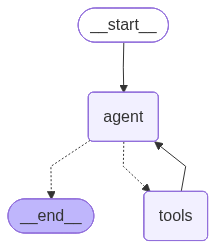


🔍 Extracting clauses...
✅ Found clause: Payment Terms
✅ Found clause: Indemnification
✅ Found clause: Warranties
✅ Found red flag: High
✅ Found red flag: Medium
✅ Found red flag: Critical
✅ Found red flag: High
✅ Found red flag: Medium

✅ Complete! (37.74s)
   Clauses: 3, Red Flags: 5



In [8]:
from app.agents.clause_extraction import ClauseExtractionAgent

print("=" * 80)
print("CLAUSE EXTRACTION AGENT")
print("=" * 80)

clause_agent = ClauseExtractionAgent(
    vector_store=vector_store,
    model_name="gpt-4o-mini",
    temperature=0.0,
    top_k=10
)

print(f"\n🤖 Agent initialized (Model: gpt-4o-mini, Tools: {len(clause_agent.tools)})")

# Visualize agent graph
try:
    graph_viz = clause_agent.get_graph_visualization()
    if graph_viz and IPYTHON_AVAILABLE:
        print("\n📊 Agent Workflow Graph:")
        display(graph_viz)
except Exception as e:
    print(f"⚠️  Graph visualization not available: {e}")

print(f"\n🔍 Extracting clauses...")
clause_start = time.time()
clause_result = clause_agent.extract_clauses(document_id=document_id)
clause_time = time.time() - clause_start

print(f"\n✅ Complete! ({clause_time:.2f}s)")
print(f"   Clauses: {len(clause_result.clauses)}, Red Flags: {len(clause_result.red_flags)}\n")

## 4.2: Risk Scoring Agent

RISK SCORING AGENT

📊 Agent Workflow Graph:


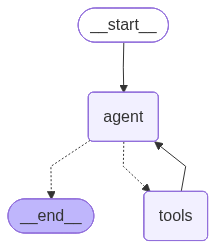


🎯 Scoring risks...

✅ Complete! (27.41s)
   Overall Risk: 65/100 (High)



In [12]:
from app.agents.risk_scoring import RiskScoringAgent

print("=" * 80)
print("RISK SCORING AGENT")
print("=" * 80)

risk_agent = RiskScoringAgent()

try:
    graph_viz = risk_agent.get_graph_visualization()
    if graph_viz and IPYTHON_AVAILABLE:
        print("\n📊 Agent Workflow Graph:")
        display(graph_viz)
except Exception as e:
    print(f"⚠️  Graph visualization not available: {e}")

print(f"\n🎯 Scoring risks...")
risk_start = time.time()
risk_result = risk_agent.score_risks(
    clause_extraction_result=clause_result,
    document_id=document_id
)

risk_time = time.time() - risk_start

print(f"\n✅ Complete! ({risk_time:.2f}s)")
print(f"   Overall Risk: {risk_result.overall_risk_score}/100 ({risk_result.overall_risk_category})\n")

## 4.3: Summary Agent

In [19]:
from app.utils.source_tracker import SourceTracker

print("=" * 80)
print("SOURCE TRACKER")
print("=" * 80)

tracker = SourceTracker(document_id=document_id)
sample_chunks = vector_store.as_retriever(search_kwargs={"k": 3}).invoke("payment terms")

source_refs = []
for i, chunk in enumerate(sample_chunks[:3], 1):
    page = chunk.metadata.get("page") if hasattr(chunk, 'metadata') else None
    source_ref = tracker.create_source_reference(
        chunk_id=f"chunk_{i}",
        text_snippet=chunk.page_content[:150],
        page=page,
        confidence=0.95
    )
    source_refs.append(source_ref)

source_metadata = tracker.create_source_metadata(
    sources=source_refs,
    extraction_method="llm_extraction"
)

links = tracker.generate_links(source_metadata)

print(f"\n✅ Created {len(source_refs)} source references")
print(f"🔗 Generated {len(links)} frontend links\n")

INFO:app.utils.source_tracker:SourceTracker initialized for document_id=31da81a9-e221-43fa-a03b-03e86eefb42e
INFO:app.rag.vector_store:Creating retriever with search_kwargs: {'k': 3}


SOURCE TRACKER

✅ Created 3 source references
🔗 Generated 3 frontend links



## 4.5: Checklist Agent

In [20]:
from app.agents.checklist import ChecklistAgent

print("=" * 80)
print("CHECKLIST AGENT")
print("=" * 80)

checklist_agent = ChecklistAgent(model_name="gpt-4o-mini", temperature=0.0)

print(f"\n📋 Generating checklist...")
checklist_start = time.time()
checklist_result = checklist_agent.generate_checklist(memo)
checklist_time = time.time() - checklist_start

print(f"\n✅ Complete! ({checklist_time:.2f}s)")
print(f"   Items: {len(checklist_result.checklist_items)}, Questions: {len(checklist_result.follow_up_questions)}\n")

INFO:app.agents.checklist:ChecklistAgent initialized with model: gpt-4o-mini
INFO:app.agents.checklist:Starting checklist generation
INFO:app.agents.checklist:Invoking ReAct agent for checklist generation


CHECKLIST AGENT

📋 Generating checklist...


INFO:app.agents.checklist:Generated 5 standard checklist items for category: Legal
INFO:app.agents.checklist:Generated 5 standard checklist items for category: Financial
INFO:app.agents.checklist:Generated 5 standard checklist items for category: Operational
INFO:app.agents.checklist:Generated 5 standard checklist items for category: Risk Management
INFO:app.agents.checklist:Generated 6 risk-based checklist items
INFO:app.agents.checklist:Generated 2 follow-up questions
INFO:app.agents.checklist:Parsed 26 checklist items and 2 questions from agent messages
INFO:app.agents.checklist:Checklist generation complete: 26 items, 2 questions in 26.50s



✅ Complete! (26.50s)
   Items: 26, Questions: 2



---
# Part 5: End-to-End Orchestration
---

In [21]:
from app.orchestration.pipeline import DocumentOrchestrator

print("=" * 80)
print("END-TO-END ORCHESTRATION")
print("=" * 80)

orchestrator = DocumentOrchestrator(model_name="gpt-4o-mini", temperature=0.0)

print(f"\n🚀 Running complete pipeline (this may take 2-4 minutes)...")
orch_start = time.time()
orch_results = orchestrator.run_orchestration(
    document_path=str(sample_doc),
    document_id="freedom_asset_agreement"
)
orch_time = time.time() - orch_start

print(f"\n✅ Orchestration Complete! ({orch_time:.2f}s)")
print(f"   Status: {orch_results['status']}")
print(f"   Steps: {len(orch_results['completed_steps'])}/6\n")

INFO:app.rag.vector_store:Initializing in-memory Qdrant client
INFO:app.rag.chunking:Initialized SemanticChunker (using_langchain=False) with threshold_type=percentile, threshold_amount=95.0, embedding_model=text-embedding-3-small
INFO:app.pipelines.ingestion_pipeline:IngestionPipeline initialized with shared vector store
INFO:app.agents.clause_extraction:ClauseExtractionAgent initialized with create_react_agent (lazy retriever)
INFO:app.agents.risk_scoring:RiskScoringAgent initialized with create_react_agent


END-TO-END ORCHESTRATION


INFO:app.agents.summary:SummaryAgent initialized with create_react_agent
INFO:app.agents.checklist:ChecklistAgent initialized with model: gpt-4o-mini
INFO:app.orchestration.pipeline:DocumentOrchestrator initialized with model=gpt-4o-mini
INFO:app.orchestration.pipeline:Starting orchestration for document: /Users/rbblankson34/Documents/Projects/Legal_AI/Legal-OS/data/Freedom_Final_Asset_Agreement.pdf
INFO:app.orchestration.pipeline:Supervisor analyzing state: current_step=start, completed=[]
INFO:app.orchestration.pipeline:Supervisor decision: next_agent=ingestion_agent
INFO:app.orchestration.pipeline:Routing to: ingestion_agent
INFO:app.orchestration.pipeline:Executing ingestion agent
INFO:app.pipelines.ingestion_pipeline:Starting ingestion for: /Users/rbblankson34/Documents/Projects/Legal_AI/Legal-OS/data/Freedom_Final_Asset_Agreement.pdf
INFO:app.pipelines.ingestion_pipeline:Loading document: /Users/rbblankson34/Documents/Projects/Legal_AI/Legal-OS/data/Freedom_Final_Asset_Agreement.


🚀 Running complete pipeline (this may take 2-4 minutes)...


INFO:app.rag.vector_store:Vectorstore created with 345 documents
INFO:app.pipelines.ingestion_pipeline:Successfully ingested Freedom_Final_Asset_Agreement.pdf: 345 chunks stored
INFO:app.orchestration.pipeline:Ingestion complete: 345 chunks created
INFO:app.orchestration.pipeline:Supervisor analyzing state: current_step=clause_extraction, completed=['ingestion']
INFO:app.orchestration.pipeline:Supervisor decision: next_agent=clause_extraction_agent
INFO:app.orchestration.pipeline:Routing to: clause_extraction_agent
INFO:app.orchestration.pipeline:Executing clause extraction agent
INFO:app.agents.clause_extraction:Starting clause extraction for document_id=freedom_asset_agreement
INFO:app.rag.retrievers:Creating naive retriever with k=10
INFO:app.rag.retrievers:Creating naive retriever with k=10
INFO:app.rag.retrievers:Creating naive retriever with k=10
INFO:app.rag.vector_store:Creating retriever with search_kwargs: {'k': 10}
INFO:app.rag.vector_store:Creating retriever with search_kwa

✅ Found clause: Payment Terms
✅ Found clause: Indemnification
✅ Found clause: Warranties
✅ Found red flag: High
✅ Found red flag: Medium
✅ Found red flag: Critical
✅ Found red flag: High
✅ Found red flag: Medium


INFO:app.agents.risk_scoring:Agent completed with 15 messages
INFO:app.agents.risk_scoring:✅ Scored Payment Terms: 65 (High)
INFO:app.agents.risk_scoring:✅ Scored Indemnification: 65 (High)
INFO:app.agents.risk_scoring:✅ Scored Warranties: 65 (High)
INFO:app.orchestration.pipeline:Risk scoring complete: 3 clauses scored, overall risk=65
INFO:app.orchestration.pipeline:Supervisor analyzing state: current_step=summary, completed=['ingestion', 'clause_extraction', 'risk_scoring']
INFO:app.orchestration.pipeline:Supervisor decision: next_agent=summary_agent
INFO:app.orchestration.pipeline:Routing to: summary_agent
INFO:app.orchestration.pipeline:Executing summary agent
INFO:app.agents.summary:Starting summary generation for document_id=freedom_asset_agreement
INFO:app.agents.summary:Processing 3 scored clauses
INFO:app.agents.summary:Agent completed with 16 messages
INFO:app.agents.summary:✅ Summary generated: 3 clause summaries, 0 findings, 5 recommendations
INFO:app.orchestration.pipelin


✅ Orchestration Complete! (150.46s)
   Status: completed
   Steps: 6/6



---
# Part 6: Results & Export
---

In [17]:
print("=" * 80)
print("PIPELINE SUMMARY")
print("=" * 80)

# Calculate total time for sequential workflow
sequential_time = (ingestion_time + rag_time + clause_time + risk_time + 
                   summary_time + checklist_time)

print(f"\n📊 Sequential Workflow:")
print(f"   Total Time: {sequential_time:.2f}s")
print(f"   - Ingestion: {ingestion_time:.2f}s")
print(f"   - RAG Test: {rag_time:.2f}s")
print(f"   - Clause Extraction: {clause_time:.2f}s")
print(f"   - Risk Scoring: {risk_time:.2f}s")
print(f"   - Summary: {summary_time:.2f}s")
print(f"   - Checklist: {checklist_time:.2f}s")

print(f"\n📊 Orchestrated Workflow:")
print(f"   Total Time: {orch_time:.2f}s")
print(f"   Efficiency: {((sequential_time - orch_time) / sequential_time * 100):.1f}% faster")

print(f"\n📊 Results:")
print(f"   Clauses Extracted: {len(clause_result.clauses)}")
print(f"   Red Flags: {len(clause_result.red_flags)}")
print(f"   Overall Risk: {risk_result.overall_risk_score}/100")
print(f"   Findings: {len(memo.key_findings)}")
print(f"   Recommendations: {len(memo.recommendations)}")
print(f"   Checklist Items: {len(checklist_result.checklist_items)}")

# Export consolidated results
export_data = {
    "document_id": document_id,
    "document_name": sample_doc.name,
    "processing_times": {
        "sequential_total": sequential_time,
        "orchestrated_total": orch_time,
        "ingestion": ingestion_time,
        "clause_extraction": clause_time,
        "risk_scoring": risk_time,
        "summary": summary_time,
        "checklist": checklist_time
    },
    "results": {
        "clauses_extracted": len(clause_result.clauses),
        "red_flags": len(clause_result.red_flags),
        "overall_risk_score": risk_result.overall_risk_score,
        "overall_risk_category": risk_result.overall_risk_category,
        "findings": len(memo.key_findings),
        "recommendations": len(memo.recommendations),
        "checklist_items": len(checklist_result.checklist_items),
        "follow_up_questions": len(checklist_result.follow_up_questions)
    }
}

results_path = backend_path / "combined_results.json"
with open(results_path, 'w') as f:
    json.dump(export_data, f, indent=2, default=str)

print(f"\n💾 Consolidated results saved to: {results_path.name}")

print("\n" + "=" * 80)
print("✅ LEGAL-OS DEMONSTRATION COMPLETE!")
print("=" * 80)
print("\nGenerated Files:")
print(f"   - {memo_path.name} (Diligence memo)")
print(f"   - {results_path.name} (Consolidated results)")
print("\nKey Achievements:")
print("   ✅ Document ingestion with shared vector store")
print("   ✅ RAG pipeline with question answering")
print("   ✅ Clause extraction with red flag detection")
print("   ✅ Risk scoring with categorization")
print("   ✅ Diligence memo generation")
print("   ✅ Source provenance tracking")
print("   ✅ Checklist and follow-up questions")
print("   ✅ End-to-end orchestration")
print("\n" + "=" * 80)

PIPELINE SUMMARY

📊 Sequential Workflow:
   Total Time: 107.56s
   - Ingestion: 8.91s
   - RAG Test: 2.39s
   - Clause Extraction: 37.74s
   - Risk Scoring: 27.41s
   - Summary: 22.98s
   - Checklist: 8.14s

📊 Orchestrated Workflow:
   Total Time: 120.96s
   Efficiency: -12.5% faster

📊 Results:
   Clauses Extracted: 3
   Red Flags: 5
   Overall Risk: 65/100
   Findings: 0
   Recommendations: 0
   Checklist Items: 20

💾 Consolidated results saved to: combined_results.json

✅ LEGAL-OS DEMONSTRATION COMPLETE!

Generated Files:
   - diligence_memo_combined.md (Diligence memo)
   - combined_results.json (Consolidated results)

Key Achievements:
   ✅ Document ingestion with shared vector store
   ✅ RAG pipeline with question answering
   ✅ Clause extraction with red flag detection
   ✅ Risk scoring with categorization
   ✅ Diligence memo generation
   ✅ Source provenance tracking
   ✅ Checklist and follow-up questions
   ✅ End-to-end orchestration

